[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaralAminpour/ML-BME-Course-UofA-Fall-2023/blob/main/Assignments/Assignment5_solved.ipynb)

# Assignment 5
### Deadline: Thursday, November 30 at 11:59 PM
#### The assignment must be submitted in the form of a Jupyter notebook and uploaded to eClass.

## Marks:
<ul type="none">
  <li><b>Exercise 1: 2 marks</b></li>
  <li><b>Exercise 2: 4 marks</b></li>
  <li><b>Exercise 3: 4 marks</b></li>
</ul>   

**Total: 10 marks**




## Part 1: Predicting age from brain structures - Regression

<img src="https://raw.githubusercontent.com/MaralAminpour/ML-BME-Course-UofA-Fall-2023/main/Week-8-Neural-Networks/imgs/BrainVolumes.png" width = "600" style="float: right;">

In exercises 1 and 2 of this assignment we will apply what we learned in week 8 to our example of prediction of age of a baby from the volumes of brain structures. We will learn how to tune the parameters of the network and design a non-linear solution.



Run the cell below to download and load the dataset with 86 structures.

In [ ]:
# This code will download the required data files from GitHub
import requests
import os
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'MaralAminpour'
    repo = 'ML-BME-Course-UofA-Fall-2023'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-8-Neural-Networks/data/GA-brain-volumes-86-features.csv', 'temp/GA-brain-volumes-86-features.csv')

This block of code will load the dataset of 86 brain volumes and convert the feature matrix and target vector to tensors.

In [ ]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def CreateFeaturesTargets(filename):

    df = pd.read_csv(filename,header=None)

    # Convert from 'DataFrame' to numpy array
    data = df.values

    # Features are in columns one to end
    X = data[:,1:]

    # Scale features
    X = StandardScaler().fit_transform(X)

    # Labels are in the column zero
    y = data[:,0].reshape(-1,1)

    # Return Features and Labels
    return X, y

X,y = CreateFeaturesTargets('temp/GA-brain-volumes-86-features.csv')

# Perform scaling of the target values to support better convergence
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])

# Convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X type: ', X.type())
print('y type: ', y.type())

Number of samples is 164
Number of features is 86
X shape:  torch.Size([164, 86])
y shape:  torch.Size([164, 1])
X type:  torch.FloatTensor
y type:  torch.FloatTensor


**Note 1:** We have converted the target values to a two dimensional vector and both feature matrix and target vector are Pytorch tensors of type `float`. This is required by Pytorch.

**Note 2:** Unlike before we performed scaling of the target values as well. This improves convergence of stochastic gradient descent (the regression techniques we used before used analytical solutions or different optimisers).

Below is the function `PlotTargets` to display true and predicted target values. Take a note of the function and run the cell.

In [ ]:
import matplotlib.pyplot as plt
def PlotTargets(y_pred,y, label = 'Target values', plot_line=True):
    if plot_line:
        plt.plot([-3,3],[-3,3],'r', label = '$y=\hat{y}$')
    plt.plot(y,y_pred,'o', label = label)

    plt.xlabel('Expected target values')
    plt.ylabel('Predicted target values')
    plt.legend()

## Exercise 1: 2 marks

In this exercise you will train and evaluate a single layer perceptron to predict the age of a baby from the volumes of 86 brain structures. First we will split the dataset into training, validation and test set.

This is different from what we have done before, but cross-validation is rarely used in deep learning, due to long training times. You will see later in this exercise how these three sets are used.

In [ ]:
from sklearn.model_selection import train_test_split

# Extract test set
groups = np.round(y/3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=groups)

# Extract validation set
groups_val = np.round(y_train/3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=groups_val)

# Display info
print('Training samples: ', y_train.shape[0])
print('Validation samples: ', y_val.shape[0])
print('Test samples: ', y_test.shape[0])

Training samples:  118
Validation samples:  21
Test samples:  25


To simplify the code, you are given three functions below:
* `train` will perform one training epoch and return the current loss value
* `validate` will return the loss value without performing any training.
* `RMSE` will calculate the root mean squared error for the trained network and dataset that you specify. It will account for the scaling of the target values as well. The result is in **weeks GA**.

Look the at functions and run the code to define the functions.

In [ ]:
# 'train' performs one training epoch and returns MSE loss
def train(net,X,y):
    # 1. Clear gradients
    optimizer.zero_grad()
    # 2. Forward pass
    prediction = net(X)
    # 3. Compute loss
    loss = loss_function(prediction, y)
    # 4. Calculate gradients
    loss.backward()
    # 5. Update network parameters
    optimizer.step()
    # Return MSE loss
    return loss.data  # we want only the loss value, not the gradients

# 'validate' calculates and returns the loss any training
def validate(net,X,y):
    with torch.no_grad():  # no need to calculate gradients
        # Forward pass
        prediction = net(X)
        # Calculate loss
        loss = loss_function(prediction, y)
        # Return MSE loss
        return loss

# 'RMSE' calculates RMSE in weeks GA
def RMSE(net,X,y):
    loss = validate(net,X,y).numpy()
    rmse = np.sqrt(loss*target_scaler.var_[0])
    return np.round(rmse,2)

Below is the code that we used to fit linear regression model to the predict brain volume from age in Notebook ```8.1-Starting-with-Pytorch.ipynb```. The code will not work for our dataset, you need to modify it.

**Task 1.1: 0.5 marks** Adjust the **architecture** of the network so that it can be used to predict age from 86 structures.

**Task 1.2: 0.5 marks** You will see that the network does not train properly. The first thing we notice is that the training loss is increasing. This may be a sign that the **learning rate** is too high. Test smaller learning rates to see whether this will solve the problem. Choose the highest learning rate that is still small enough so that the training loss does not increase.

**Task 1.3: 0.25 marks** Once you tuned your learning rate, you will probably find that the training loss is still steeply decreasing and the network has not yet converged to a good solution. Increase the number of **epochs** to 1000 and see what happens. Looking at the MSE loss plot, how many epochs did you need for the network to converge?

**Task 1.4: 0.5 marks** You may notice that the number of epochs we have is rather arbitrary, and we do not know whether it is too few, and the network did not converge yet, or too many, and the network started overfitting. You may also wonder why do we have the **validation set**. We will use it to monitor the performance of the network during training. In this task, you will implement monitoring of the training during epochs using the validation set as follows:
* Create a variable `val_losses` where you will save the validation loss at each epoch. Initialise it before the `for` loop similarly to `train_losses`.
* At each epoch call the function `validate` to calculate loss on the validation set `X_val`, `y_val`. Append the validation loss returned by the function `validate` to the variable `val_losses`.
* In the subplot `133`, plot the validation loss in addition to the training loss.
* If needed, change the number of epochs to 10000 to find out when the validation loss starts increasing.

**Task 1.5: 0.25 marks** We would of course like to choose the model that performs best on the validation set as our final trained model. We therefore need to keep training, while the loss on validation set is decreasing. Once it starts increasing, we will stop training to prevent overfitting. This technique is called **early stopping** and in fact acts as regularisation. To implement early stopping we need to `break` the `for` loop once the validation loss starts increasing. To do that, add this code at the end of the `for` loop:

`if(i>1):
     if val_losses[i-1]>val_losses[i-2]:
         print('Final iteration: ', i)
         break`

**Note:** Not all runs of the network will perform equally well. This is because we are using gradient descent and the weights of the network are initialised to random values. Therefore the fit will not always converge to an optimal solution. But you will also see that some runs produce a good solution, similar to the penalised regression techniques that we have covered earlier in this module.

ANRegressor(
  (layer): Linear(in_features=86, out_features=1, bias=True)
)
Final iteration:  807
Training RMSE:  0.75
Validation RMSE:  1.4
Test RMSE:  1.25


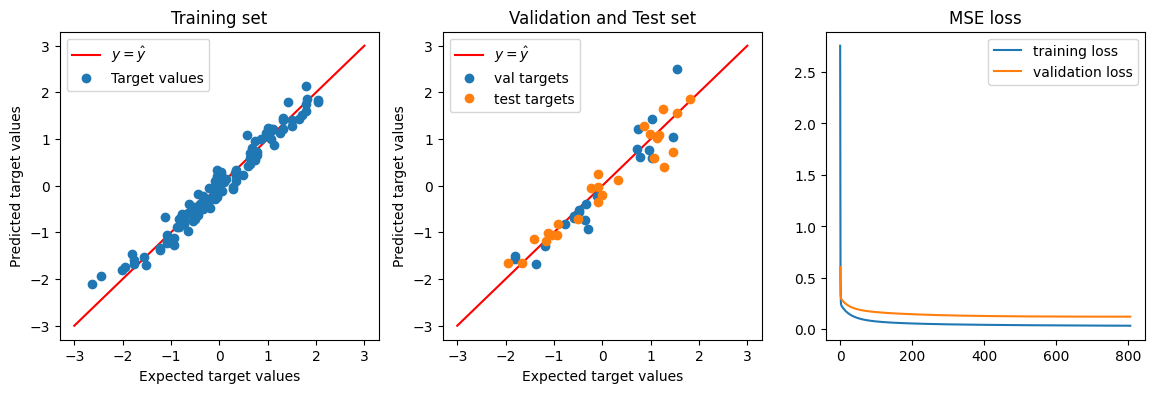

In [ ]:
import torch.nn as nn
class ANRegressor(nn.Module):
    def __init__(self):
        super(ANRegressor, self).__init__()
        self.layer = nn.Linear(86, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

# Create network
net = ANRegressor()
print(net)

# Mean squared error loss
loss_function = nn.MSELoss()

# Stochastic gradient descent optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)  # other values could be acceptable

# Train
train_losses=[]
val_losses = []
for i in range(1000):
    loss = train(net, X_train, y_train)
    train_losses.append(loss) # we save losses to display them at the end
    val_losses.append(validate(net, X_val, y_val))
    if i>1:
        if val_losses[i-1]>val_losses[i-2]:
            print('Final iteration: ', i)
            break

# Calculate training and test performance
rmse_train = RMSE(net,X_train,y_train)
print('Training RMSE: ', rmse_train)
rmse_val = RMSE(net,X_val,y_val)
print('Validation RMSE: ', rmse_val)
rmse_test = RMSE(net,X_test,y_test)
print('Test RMSE: ', rmse_test)

# Display results
plt.figure(figsize=(14,4))

# Plot training set predictions
plt.subplot(131)
PlotTargets(net(X_train).data,y_train)
plt.title('Training set')

# Plot validation and test set predictions
plt.subplot(132)
PlotTargets(net(X_val).data, y_val, label = 'val targets')
PlotTargets(net(X_test).data,y_test, label = 'test targets', plot_line=False)
plt.title('Validation and Test set')

# Plot training and validation loss
plt.subplot(133)
plt.plot(train_losses,label='training loss')
plt.title('MSE loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

## Exercise 2: 4 marks

We will now tune a multi-layer perceptron to predict age from 6 brain volumes.

First, we will download and load the dataset with 6 brain structures.

In [ ]:
# This code will download the required data files from GitHub
import requests
import os
def download_data(source, dest):
    base_url = 'https://raw.githubusercontent.com/'
    owner = 'MaralAminpour'
    repo = 'ML-BME-Course-UofA-Fall-2023'
    branch = 'main'
    url = '{}/{}/{}/{}/{}'.format(base_url, owner, repo, branch, source)
    r = requests.get(url)
    f = open(dest, 'wb')
    f.write(r.content)
    f.close()

# Create the temp directory, if it doesn't already exist
if not os.path.exists('temp'):
   os.makedirs('temp')

download_data('Week-8-Neural-Networks/data/GA-brain-volumes-6-features.csv', 'temp/GA-brain-volumes-6-features.csv')

**Task 2.1: 0.5 marks** Fill in the missing code to convert the feature matrix and target vector from numpy arrays to a format suitable for training in Pytorch.

In [ ]:
X, y = CreateFeaturesTargets('temp/GA-brain-volumes-6-features.csv')  # Note that this will overwrite X, y that we created in the previous exercise

# Perform scaling of the target values to support better convergence
target_scaler = StandardScaler()
y = target_scaler.fit_transform(y)

print('Number of samples is', X.shape[0])
print('Number of features is', X.shape[1])

# Convert to tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X type: ', X.type())
print('y type: ', y.type())

Number of samples is 164
Number of features is 6
X shape:  torch.Size([164, 6])
y shape:  torch.Size([164, 1])
X type:  torch.FloatTensor
y type:  torch.FloatTensor


**Task 2.2: 0.5 marks** Create training, validation and test set similarly to exercise 1.

In [ ]:
# Extract test set
groups = np.round(y/3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=groups)

# Extract validation set
groups_val = np.round(y_train/3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42, stratify=groups_val)

# Display info
print('Training samples: ', y_train.shape[0])
print('Validation samples: ', y_val.shape[0])
print('Test samples: ', y_test.shape[0])

Training samples:  118
Validation samples:  21
Test samples:  25


**Task 2.3: 1 mark** Perform training and evaluation of the performance using the same code as you developed in Exercise 1. You need to adapt the architecture to take 6 input features, but other than that the code should work. Adjust the learning rate to achieve optimal performance.

MLPRegressor(
  (layer): Linear(in_features=6, out_features=1, bias=True)
)
Final iteration:  1753
Training RMSE:  1.17
Validation RMSE:  1.17
Test RMSE:  1.12


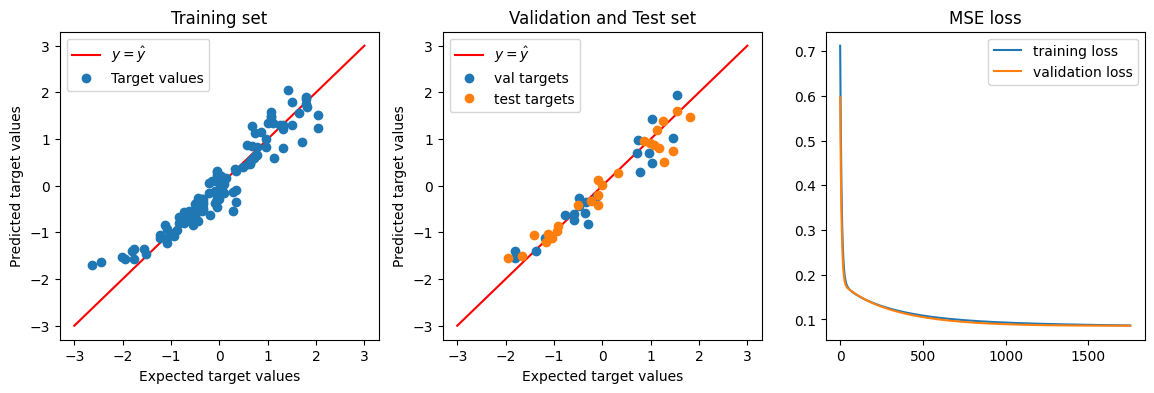

In [ ]:
import torch.nn as nn
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layer = nn.Linear(6, 1)

    def forward(self, x):
        x = self.layer(x)
        return x

# Create network
net = MLPRegressor()
print(net)

# Mean squared error loss
loss_function = nn.MSELoss()

# Stochastic gradient descent optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)  # other values could be acceptable

# Train
train_losses=[]
val_losses = []
for i in range(10000):
    loss = train(net, X_train, y_train)
    train_losses.append(loss) # we save losses to display them at the end
    val_losses.append(validate(net, X_val, y_val))
    if i>1:
        if val_losses[i-1]>val_losses[i-2]:
            print('Final iteration: ', i)
            break

# Calculate training and test performance
rmse_train = RMSE(net,X_train,y_train)
print('Training RMSE: ', rmse_train)
rmse_val = RMSE(net,X_val,y_val)
print('Validation RMSE: ', rmse_val)
rmse_test = RMSE(net,X_test,y_test)
print('Test RMSE: ', rmse_test)

# Display results
plt.figure(figsize=(14,4))

# Plot training set predictions
plt.subplot(131)
PlotTargets(net(X_train).data,y_train)
plt.title('Training set')

# Plot validation and test set predictions
plt.subplot(132)
PlotTargets(net(X_val).data, y_val, label = 'val targets')
PlotTargets(net(X_test).data,y_test, label = 'test targets', plot_line=False)
plt.title('Validation and Test set')

# Plot training and validation loss
plt.subplot(133)
plt.plot(train_losses,label='training loss')
plt.title('MSE loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

**Task 2.4: 1.5 marks** Modify the code from task 2.3 further to implement a multi-layer perceptron architecture as follows:
* First `Linear` layer with 6 outputs
* `ReLU` activation
* Second `Linear` layer with 6 inputs and 1 output

MLPRegressor(
  (layer1): Linear(in_features=6, out_features=6, bias=True)
  (relu): ReLU()
  (layer2): Linear(in_features=6, out_features=1, bias=True)
)
Final iteration:  79
Training RMSE:  1.05
Validation RMSE:  0.91
Test RMSE:  0.66


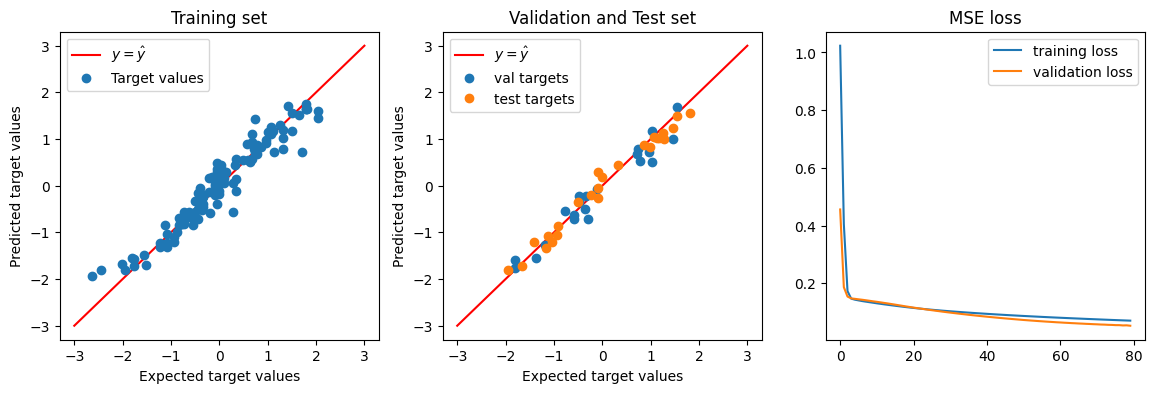

In [ ]:
import torch.nn as nn
class MLPRegressor(nn.Module):
    def __init__(self):
        super(MLPRegressor, self).__init__()
        self.layer1 = nn.Linear(6, 6)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(6, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

# Create network
net = MLPRegressor()
print(net)

# Mean squared error loss
loss_function = nn.MSELoss()

# Stochastic gradient descent optimiser
optimizer = torch.optim.SGD(net.parameters(), lr=0.2)  # other values could be acceptable

# Train
train_losses=[]
val_losses = []
for i in range(1000):
    loss = train(net, X_train, y_train)
    train_losses.append(loss) # we save losses to display them at the end
    val_losses.append(validate(net, X_val, y_val))
    if i>1:
        if val_losses[i-1]>val_losses[i-2]:
            print('Final iteration: ', i)
            break

# Calculate training and test performance
rmse_train = RMSE(net,X_train,y_train)
print('Training RMSE: ', rmse_train)
rmse_val = RMSE(net,X_val,y_val)
print('Validation RMSE: ', rmse_val)
rmse_test = RMSE(net,X_test,y_test)
print('Test RMSE: ', rmse_test)

# Display results
plt.figure(figsize=(14,4))

# Plot training set predictions
plt.subplot(131)
PlotTargets(net(X_train).data,y_train)
plt.title('Training set')

# Plot validation and test set predictions
plt.subplot(132)
PlotTargets(net(X_val).data, y_val, label = 'val targets')
PlotTargets(net(X_test).data,y_test, label = 'test targets', plot_line=False)
plt.title('Validation and Test set')

# Plot training and validation loss
plt.subplot(133)
plt.plot(train_losses,label='training loss')
plt.title('MSE loss')
plt.plot(val_losses, label='validation loss')
plt.legend()
plt.show()

**Question 2.1: 0.5 marks** Can you achieve better performance with this non-linear network? Can you hypothesize why/why not?

## Part 2: Your own Single Layer Perceptron - Classification

## Exercise 3: 4 marks

In this exercise you will implement and train your own single layer perceptron classifier using the Wiscosin Breast Cancer dataset.


Run the cells to load the feature matrix and the label vector and split the data into training and validation set.

In [ ]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import requests
import os

# Load feature matrix and label vector
data = datasets.load_breast_cancer()
X = StandardScaler().fit_transform(data.data)
y = data.target

print('Features dim: ', X.shape)
print('Labels dim: ', y.shape)
print('We have {} samples and {} features.'.format(X.shape[0],X.shape[1]))
print('We have labels: ', np.unique(y))

Features dim:  (569, 30)
Labels dim:  (569,)
We have 569 samples and 30 features.
We have labels:  [0 1]


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print('Training samples: ', y_train.shape[0])
print('Validation samples: ', y_test.shape[0])

Training samples:  455
Validation samples:  114


### Architecture
Our single layer perceptron will consist of

1 linear layer with 30 inputs and 1 output
A sigmoid activation function
We will minimise the mean squared error loss.

The functions below implement these elements of the architecture, plus there is a function to calculate a generic derivative. Review this functions and run the cell.

In [ ]:
# Sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))

# Linear layer - we do not have a bias here for simplicity
def linear(x,w):
    return np.matmul(x, w)

# Mean squared error loss
def mse(y, y_pred):
    return np.mean(np.square(y-y_pred))

# A general derivative of a function (no need to implement individual derivatives)
def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

### Theory review
The single layer perceptron is composed of one **linear layer** of neurons that can be expressed as
$$z=Xw$$
where $X$ is the feature matrix, $w$ are the parameters of the network and $z$ is the output of the linear layer.
**Note**: we will not implement the bias term in this exercise for simplicity.

The output of the linear layer is passed through the activation function, which in our case is **sigmoid** $\sigma$:
$$p=\sigma(z)$$
The output $p$ is the probability of the positive class 1.

We will find the network parameter vector $w$ by **minimising the mean squared error loss** between predicted probability $p$ and true labels $y$:
$$loss=\sum_{n=1}^N(y_n-p_n)^2$$

We can iteratively **update the weight vector** $w$ with the gradient descent equation:
$$w^{iter+1}=w^{iter}-\eta \frac{\partial loss}{\partial w}$$
where $w^{iter}$ is the estimated weight vector at the iteration $iter$ and $\eta$ is the learning rate.

In the case of MSE loss and sigmoid activation, the derivative is
$$\frac{\partial loss}{\partial w}=(y-p)\sigma'(z)X$$

### Training

Complete the code below to train the single layer perceptron. The learning rate and number of epoch has been already set for you. We start by initialising the weight vector `w` to random values.

**Task 3.1: 0.25 marks** Implement the forward pass. To do that:
* evaluate the linear layer for the training feature matrix `X_train`;
* pass the result through the sigmoid activation.

**Task 3.2: 0.25 marks** Calculate the training loss. There is also code to save it for plotting after we finished training.

**Task 3.3: 0.5 marks** Implement the backward pass. To do that you need to implement the calculation of the gradients of the:
* loss
* activation
* linear layer
The code to multiply them together using the chain rule is provided.

**Task 3.4: 0.25 marks** Implement the update of the network weights.

Once you successfully complete the code, run it. You will see how the loss is evolving.

Weight vector dimension:  (30,)
Epoch 0: MSE = 0.74
Epoch 1: MSE = 0.6804
Epoch 2: MSE = 0.5853
Epoch 3: MSE = 0.4465
Epoch 4: MSE = 0.2783
Epoch 5: MSE = 0.1172
Epoch 6: MSE = 0.0647
Epoch 7: MSE = 0.0456
Epoch 8: MSE = 0.0369
Epoch 9: MSE = 0.033
Epoch 10: MSE = 0.0306
Epoch 11: MSE = 0.0288
Epoch 12: MSE = 0.0273
Epoch 13: MSE = 0.0261
Epoch 14: MSE = 0.025
Epoch 15: MSE = 0.0241
Epoch 16: MSE = 0.0233
Epoch 17: MSE = 0.0226
Epoch 18: MSE = 0.022
Epoch 19: MSE = 0.0215


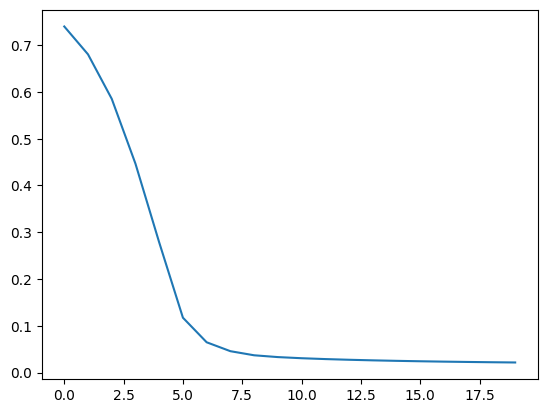

In [ ]:
# Set learning rate
lr = 0.01

# Set number of epochs
epochs = 20

# Initialize the weights randomly with mean 0
w = 2*np.random.random(np.array(X).shape[1]) - 1
print('Weight vector dimension: ', w.shape)

# Training loop
train_loss = []
for iter in range(epochs):

    # 3.1 Forward pass - predict network output
    # Implement linear layer
    z = linear(X_train, w)
    # Predict output probabilities
    p_pred = sigmoid(z)

    # 3.2 Calculate and save training loss
    loss = mse(y_train, p_pred)
    train_loss.append(loss)

    print('Epoch {}: MSE = {}'.format(iter,np.round(loss,4)))

    # 3.3 Backward pass - calculate gradients
    # Gradient of the loss: error between predicted and true training labels
    loss_grad = p_pred - y_train
    # Gradient of activation: derivative of sigmoid
    act_grad = derivative(sigmoid, z)
    # Gradient of linear layer: feature matrix
    lin_grad = X_train
    # Multiply gradients (chain rule)
    grad = np.matmul(loss_grad*act_grad,lin_grad)

    # 3.4 Update the weights of the network
    w -= grad*lr

# Plot training loss during epochs
plt.plot(train_loss)
plt.show()

**Task 3.5: 0.5 marks** Evaluate the accuracy of the trained network on training and test set. To do that:
* implement the forward pass of the network on the training set to calculate the predicted labels (code given);
* evaluate the accuracy on the training set using the given function `accuracy`;
* implement the forward pass of the network in test set;
* evaluate the accuracy for the test set.

In [ ]:
def accuracy(y,y_pred):
    a = np.sum(y==y_pred)/y.shape[0]
    return a

# Predict on training set
y_pred = np.around(sigmoid(linear(X_train,w)))
acc_train = accuracy(y_train, y_pred)
print('Train accuracy: ', np.round(acc_train,2))

# Predict on test set
y_pred_test = np.around(sigmoid(linear(X_test,w)))
acc_test = accuracy(y_test, y_pred_test)
print('Test accuracy: ', np.round(acc_test,2))

Train accuracy:  0.97
Test accuracy:  0.92


### Cross Entropy Loss

You already know that binary cross-entropy loss is more common to use for binary classification rather than MSE loss. **Binary Cross-entropy loss** is given by
$$BCELoss=\sum_{n=1}^N(-y_n \log(p_n)-(1-y_n)\log(1-p_n))$$

We have used MSE loss in the lecture instead, because it is easier to calculate the derivatives. However, the derivative of BCE loss with sigmoid activation with respect to the weights actually results in a much simple derivative:

$$\frac{\partial BCELoss}{\partial w}=(y-p)X$$

**Task 3.6: 0.25 marks** Complete the implementation of BCE loss in the cell below.

In [ ]:
# Binary Cross-entropy loss
def BCE(y,p):
    return -np.mean(np.log(p)*y + (1-y)*np.log(1-p))

**Task 3.7: 2 marks** Implement the gradient of the binary cross entropy loss and train the single layer perceptron using the code below.

Epoch 0: BCE = 1.0294
Epoch 1: BCE = 0.2943
Epoch 2: BCE = 0.2415
Epoch 3: BCE = 0.2122
Epoch 4: BCE = 0.1926
Epoch 5: BCE = 0.1782
Epoch 6: BCE = 0.167
Epoch 7: BCE = 0.1581
Epoch 8: BCE = 0.1508
Epoch 9: BCE = 0.1446
Epoch 10: BCE = 0.1394
Epoch 11: BCE = 0.1348
Epoch 12: BCE = 0.1309
Epoch 13: BCE = 0.1274
Epoch 14: BCE = 0.1243
Epoch 15: BCE = 0.1214
Epoch 16: BCE = 0.1189
Epoch 17: BCE = 0.1166
Epoch 18: BCE = 0.1144
Epoch 19: BCE = 0.1125
Train accuracy:  0.96
Test accuracy:  0.89


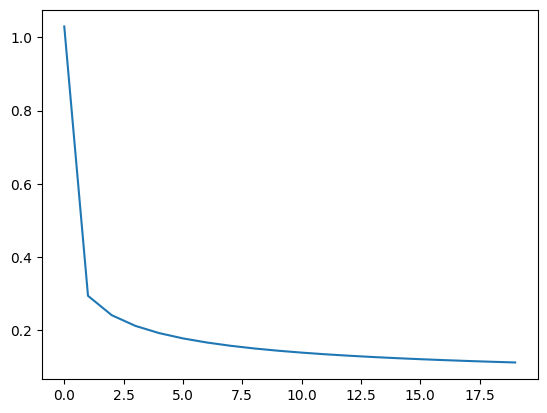

In [ ]:
# Set learning rate
lr = 0.001

# Set number of epochs
epochs = 20

# Initialize the weights randomly with mean 0
w = 2*np.random.random(np.array(X).shape[1]) - 1

# Training loop
train_loss = []
for iter in range(epochs):

    # Forward pass - predict labels
    z = linear(X_train,w)
    p_pred = sigmoid(z) # probabilities

    # Calculate and save training loss (need to thredhol)
    loss = BCE(y_train,p_pred)
    train_loss.append(loss)

    print('Epoch {}: BCE = {}'.format(iter,np.round(loss,4)))

    # Backward pass - calculate gradients
    # Error
    error = p_pred-y_train
    # Gradient
    grad = np.matmul(error,X_train)

    # Update the weights of the network
    w -= grad * lr

plt.plot(train_loss)

# Predict on training set
y_pred = np.around(sigmoid(linear(X_train,w)))
acc_train = accuracy(y_train,y_pred)
print('Train accuracy: ', np.round(acc_train,2))

# Predict on test set
y_pred_test = np.around(sigmoid(linear(X_test,w)))
acc_test = accuracy(y_test,y_pred_test)
print('Test accuracy: ', np.round(acc_test,2))